# 表格模型

In [57]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

这节课用到的库和一些变量

碰到推荐问题的同时，除了深度学习，还有两种其他算法可以使用。比如：

- 一些决策树算法（比如随机森林和gradient boosting machine)这些方法主要是用于结构型的数据（表格数据）。
- 深层神经网络，多用于非结构性的数据，如视频，音频，图像等等。

这节课的数据集是kaggle上来的，kaggle上有很多有意思的竞赛，有机会可以玩一玩,在调用API下载数据之前需要在网站中的rules点下确定才能下载

In [58]:
creds = '"username":"meiyoufeng","key":"fcb184f8b0199f1c349ae9dbbe932f1f"'

In [59]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [60]:
path = URLs.path('bluebook')
path

Path('.')

In [61]:
#hide
Path.BASE_PATH = path

In [62]:
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

  0%|          | 0.00/48.4M [00:00<?, ?B/s]Downloading bluebook-for-bulldozers.zip to C:\Users\94323\.fastai\archive\bluebook
100%|██████████| 48.4M/48.4M [00:09<00:00, 5.39MB/s]



(#0) []

In [63]:
path.ls()

(#15) [Path('bluebook-for-bulldozers.zip'),Path('Data Dictionary.xlsx'),Path('Machine_Appendix.csv'),Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv'),Path('Test.csv'),Path('Train.7z'),Path('Train.zip'),Path('TrainAndValid.7z'),Path('TrainAndValid.csv')...]

数据下载完成之后，我们来看看数据的结构是什么样的

In [64]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [66]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

里面字段挺多的，很多都会自动处理，但是在数据预处理的时候有一点要注意，有一些离散的字段需要标出来，比如说：`ProductSize`

In [67]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

这个字段表示的是产品的型号，有中号，小号，大号等等，这个标签信息很明显是离散的，所以在处理的时候要特别标出来，使用`astype()`函数来标出这个字段是一种分类字段，同时使用set_categories()函数，里面的参数ordered的值设置为true，比如：

In [69]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [70]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

kaggle上面的竞赛一般都会规定loss函数，比如这个case他们要求的就是 root mean squared log error (RMSLE) 

In [71]:
dep_var = 'SalePrice'

In [72]:
df[dep_var] = np.log(df[dep_var])

 ## 决策树

决策树在此不做非常详细的讲解，简单说决策树模型就是让电脑知道这是一种二分类模型，在树的每一层里都有若干个条件，通过条件的是否来判断是否属于这种叶节点。

<img alt="An example of decision tree" width="600" caption="An example of decision tree" id="decision_tree" src="images/decision_tree.PNG">

课上也提到了简单快速创建决策树的方法

1. 看下数据集中的每一列。
2. 对于每一列来说，遍历每种可能的取值，比如产品的规格有大、中、小、很小这四种取值。
3. 将数据分为两组，对于连续数据来说，基于他们的值大于或者小于某种尺度来分类，而对于离散不连续变量来说，基于是否符合这个值来进行分类。
4. 找到这两组数据的平均价格，看看不同组的平均价格的距离有多近，将相应组中的数据的平均值作为模型的预测值。
5. 重复第三和第四步，不停的找到不同的两个组别他们的均方误差，直到这个值最小为止。

## 一些数据的预处理

In [75]:
df = add_datepart(df, 'saledate')
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')
' '.join(o for o in df.columns if o.startswith('sale'))

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

添加销售日期

除此之外，还需要做一些数据的清洗，使用到的类是fastai中的TabularPandas和TabularProc。特别是TabularProc中的categorify和FillMissing这两个类，前者是用来处理序数型数据的，后者是用来处理缺失数据，将缺失数据使用数据的中位数代替。



In [74]:
procs = [Categorify, FillMissing]

In [76]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

用.show()方法可以显示表格中的数据

In [77]:
#hide_output
to.show(3)

,SalesID,MachineID,saleWeek,ModelID,datasource,YearMade,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,auctioneerID,MachineHoursCurrentMeter,SalePrice
0,1139246,999089,46,3157,121,2004,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,2006,11,16,3,320,False,False,False,False,False,False,1163635200,False,False,3.0,68.0,11.097410
1,1139248,117657,13,77,121,1996,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,2004,3,26,4,86,False,False,False,False,False,False,1080259200,False,False,3.0,4640.0,10.950807
2,1139249,434808,9,7009,121,2001,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2004,2,26,3,57,False,False,False,False,False,False,1077753600,False,False,3.0,2838.0,9.210340


.classes()方法可以查看被编码成数据的原本的类型

In [78]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

保存这个表格

In [80]:
save_pickle(path/'to.pkl',to)

读取这个表格


`to = load_pickle(path/'to.pkl')`

## 创建决策树模型

In [81]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

使用decisiontreeregressor()函数来建模，这个maxleafnodes的参数是告诉建模器最大的叶节点的数量

In [82]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

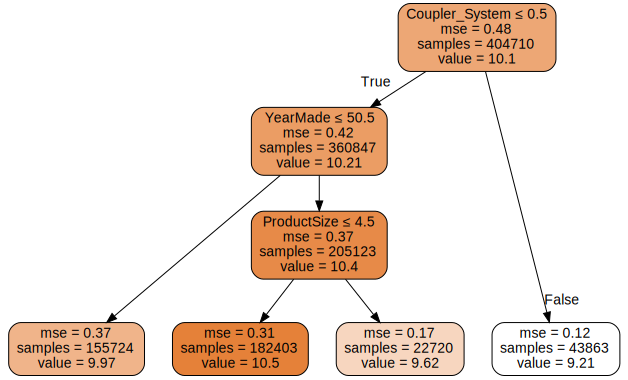

In [83]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [85]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

ExecutableNotFound: failed to execute ['dot', '-Tsvg', '-o', 'C:\\Users\\94323\\AppData\\Local\\Temp\\DTreeViz_20104.svg', 'C:/Users/94323/AppData/Local/Temp\\DTreeViz_20104'], make sure the Graphviz executables are on your systems' PATH

In [86]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

ExecutableNotFound: failed to execute ['dot', '-Tsvg', '-o', 'C:\\Users\\94323\\AppData\\Local\\Temp\\DTreeViz_20104.svg', 'C:/Users/94323/AppData/Local/Temp\\DTreeViz_20104'], make sure the Graphviz executables are on your systems' PATH

我们再将这个函数运行一遍，但是去掉最大叶节点数量，模型这样就会自动去判断这个叶节点数量

In [87]:
m = DecisionTreeRegressor()
m.fit(xs, y);

然后我们看看这个模型的均方误差是多少

In [88]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

对于训练集来说，这个误差是特别完美的0，也就是说根本没有任何误差，这就出现了一个非常非常经典的情况，过拟合。

In [89]:
m_rmse(m, xs, y)

0.0

我们再来看看测试集的误差，要大于验证集的误差，证实了模型出现了过拟合的情况

In [90]:
m_rmse(m, valid_xs, valid_y)

0.392152

In [91]:
m.get_n_leaves(), len(xs)

(324591, 404710)

原因在于模型总共的叶节点有32w个，但是总共的数据有40w个，这叶节点数量和总数量都差不多了，也就是说基本出现在训练集中的每一个情况都被完整的进行了分类。这样做明显不合理。

解决的办法就是使用一些其他的停止条件，比如我们将其规定在有25个叶节点的时候就停止计算，这样的话结果就会好很多。

In [92]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.211677, 0.288386)